In [ ]:
# default_exp instance_segmentation.model

# Model

> The goal of this challenge is to find all instances of dolphins in a picture and then color pixes of each dolphin with a unique color.

In [ ]:
# export

from pathlib import Path
from typing import List, Tuple, Union, Optional, Dict, Set

In [ ]:
# exporti

import numpy as np
from datetime import datetime
import PIL
from PIL import Image
from zipfile import ZipFile
import random
import utils
import math

import torch
import torch.utils.data
from torch.hub import download_url_to_file

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import ToPILImage

from dolphins_recognition_challenge.datasets import stack_imgs
from dolphins_recognition_challenge.utils import *

from dolphins_recognition_challenge.datasets import get_dataset

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
#hide

for m in [np, torch, torchvision, PIL]:
    print(f"{m.__name__:12}: {m.__version__}")

numpy       : 1.18.5
torch       : 1.7.1
torchvision : 0.8.2
PIL         : 7.2.0


In [ ]:
#hide
import pandas as pd
import seaborn as sns

## Model

Here is an example of how to create a model for instance segmentation:

In [ ]:
def get_instance_segmentation_model(hidden_layer_size, box_score_thresh=0.5):
    # our dataset has two classes only - background and dolphin    
    num_classes = 2
    
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        pretrained=True,
        box_score_thresh=0.5,
    )

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_channels=in_features_mask, 
        dim_reduced=hidden_layer_size,
        num_classes=num_classes
    )

    return model

In [ ]:

# get the model using our helper function
model = get_instance_segmentation_model(hidden_layer_size=256)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
#export

def train_one_epoch(
    model,
    optimizer,
    data_loader,
    device,
    epoch,
    print_freq=10,
):
    """ Trains one epoch of the model. Copied from the reference implementation from https://github.com/pytorch/vision.git.
    """
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


For training the model, you can use `train_one_epoch` as follows:

In [ ]:
#hide

num_epochs = 1

from dolphins_recognition_challenge.datasets import ToTensor, RandomHorizontalFlip, Compose

class MyColorJitter:
    def __init__(self, brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5):
        self.torch_color_jitter = torchvision.transforms.ColorJitter(
            brightness=brightness, contrast=contrast, saturation=saturation, hue=hue
        )

    def __call__(self, image, target):
        image = self.torch_color_jitter(image)
        return image, target
    
def get_my_tensor_transforms(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(RandomHorizontalFlip(0.5))
        transforms.append(MyColorJitter())
        # TODO: add additional transforms: e.g. random crop
    return Compose(transforms)

In [ ]:
#hide_output

data_loader, data_loader_test = get_dataset("segmentation", batch_size=4, get_tensor_transforms=get_my_tensor_transforms)

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=20)

    lr_scheduler.step()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/40]  eta: 0:00:49  lr: 0.000133  loss: 6.3741 (6.3741)  loss_classifier: 0.5983 (0.5983)  loss_box_reg: 0.3189 (0.3189)  loss_mask: 5.1650 (5.1650)  loss_objectness: 0.1840 (0.1840)  loss_rpn_box_reg: 0.1079 (0.1079)  time: 1.2305  data: 0.7283  max mem: 4478
Epoch: [0]  [20/40]  eta: 0:00:10  lr: 0.002695  loss: 1.0327 (1.8760)  loss_classifier: 0.2106 (0.2628)  loss_box_reg: 0.2570 (0.2503)  loss_mask: 0.5184 (1.3079)  loss_objectness: 0.0157 (0.0308)  loss_rpn_box_reg: 0.0143 (0.0243)  time: 0.4737  data: 0.0074  max mem: 5184
Epoch: [0]  [39/40]  eta: 0:00:00  lr: 0.005000  loss: 0.6628 (1.3247)  loss_classifier: 0.1068 (0.1925)  loss_box_reg: 0.2223 (0.2389)  loss_mask: 0.2813 (0.8271)  loss_objectness: 0.0151 (0.0269)  loss_rpn_box_reg: 0.0204 (0.0393)  time: 0.4774  data: 0.0082  max mem: 5184
Epoch: [0] Total time: 0:00:19 (0.4960 s / it)


In [ ]:
# hide
# slow

# let's train it for 15 epochs
num_epochs = 15

print("Training...")
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=20)
    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)

Training...
Epoch: [0]  [ 0/40]  eta: 0:00:47  lr: 0.000133  loss: 0.5469 (0.5469)  loss_classifier: 0.0729 (0.0729)  loss_box_reg: 0.2343 (0.2343)  loss_mask: 0.2184 (0.2184)  loss_objectness: 0.0109 (0.0109)  loss_rpn_box_reg: 0.0103 (0.0103)  time: 1.1906  data: 0.7168  max mem: 5184
Epoch: [0]  [20/40]  eta: 0:00:10  lr: 0.002695  loss: 0.5537 (0.5793)  loss_classifier: 0.0830 (0.0849)  loss_box_reg: 0.2140 (0.2147)  loss_mask: 0.2234 (0.2293)  loss_objectness: 0.0118 (0.0138)  loss_rpn_box_reg: 0.0088 (0.0365)  time: 0.4815  data: 0.0076  max mem: 5184
Epoch: [0]  [39/40]  eta: 0:00:00  lr: 0.005000  loss: 0.5284 (0.5636)  loss_classifier: 0.0774 (0.0836)  loss_box_reg: 0.1736 (0.2064)  loss_mask: 0.2216 (0.2277)  loss_objectness: 0.0078 (0.0128)  loss_rpn_box_reg: 0.0177 (0.0330)  time: 0.4953  data: 0.0078  max mem: 5184
Epoch: [0] Total time: 0:00:20 (0.5080 s / it)
Epoch: [1]  [ 0/40]  eta: 0:00:51  lr: 0.005000  loss: 0.8058 (0.8058)  loss_classifier: 0.1713 (0.1713)  loss_bo

Epoch: [9]  [39/40]  eta: 0:00:00  lr: 0.000500  loss: 0.2287 (0.2751)  loss_classifier: 0.0340 (0.0389)  loss_box_reg: 0.0625 (0.0797)  loss_mask: 0.1224 (0.1360)  loss_objectness: 0.0013 (0.0029)  loss_rpn_box_reg: 0.0045 (0.0177)  time: 0.5408  data: 0.0076  max mem: 5185
Epoch: [9] Total time: 0:00:22 (0.5568 s / it)
Epoch: [10]  [ 0/40]  eta: 0:00:49  lr: 0.000500  loss: 0.1827 (0.1827)  loss_classifier: 0.0314 (0.0314)  loss_box_reg: 0.0485 (0.0485)  loss_mask: 0.0955 (0.0955)  loss_objectness: 0.0045 (0.0045)  loss_rpn_box_reg: 0.0028 (0.0028)  time: 1.2462  data: 0.7307  max mem: 5185
Epoch: [10]  [20/40]  eta: 0:00:11  lr: 0.000500  loss: 0.2499 (0.2431)  loss_classifier: 0.0340 (0.0353)  loss_box_reg: 0.0745 (0.0706)  loss_mask: 0.1223 (0.1252)  loss_objectness: 0.0008 (0.0016)  loss_rpn_box_reg: 0.0043 (0.0103)  time: 0.5365  data: 0.0068  max mem: 5185
Epoch: [10]  [39/40]  eta: 0:00:00  lr: 0.000500  loss: 0.2658 (0.2573)  loss_classifier: 0.0373 (0.0366)  loss_box_reg: 0.

In [ ]:
# hide
# # evaluate on the test dataset
# evaluate(model, data_loader_test, device=device)

In [ ]:
#export

def show_prediction(
    model,
    img: torch.Tensor(),
    *,
    score_limit: float=0.5,
    width: int=800
) -> None:
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # convert Tensor to PIL Image
    img_bg = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    images = [img_bg]

    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    predicted_masks = prediction[0]["masks"]
    scores = prediction[0]["scores"]

    for i in range(predicted_masks.shape[0]):
        score = scores[i]
        if score >= score_limit:
            bg = img_bg.copy()
            fg = Image.fromarray(predicted_masks[i, 0].mul(255).byte().cpu().numpy())
            bg.paste(fg.convert("RGB"), (0, 0), fg)
            images.append(bg)

    display(stack_imgs(images, width))


Show predictions on a single input image:

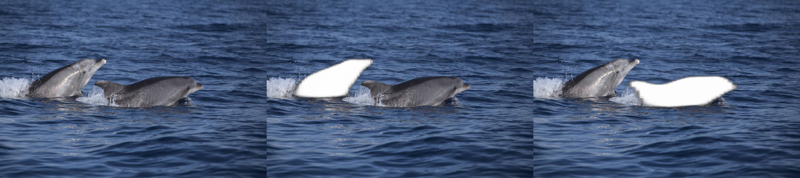

In [ ]:
# pick one image from the test set
img, _ = data_loader_test.dataset[14]
    
show_prediction(model, img)

We can also show predictions for the whole or for a subset of the dataset from a dataloader object:

In [ ]:
#export

def show_predictions(
    model,
    *,
    data_loader=None,
    dataset=None,
    n=None,
    score_limit=0.5,
    width=800
):
    assert (data_loader is None) ^ (dataset is None), f"only one of dataloader ({dataloader}) and dataset({dataset}) must be defined"
    
    if data_loader:
        dataset = data_loader.dataset
        
    if n == None:
        n = len(dataset)
    else:
        n = min(n, len(dataset))

    for i in range(n):
        show_prediction(model, img=dataset[i][0], score_limit=score_limit, width=width)

Shows predictions for the first two elements in the data loader:

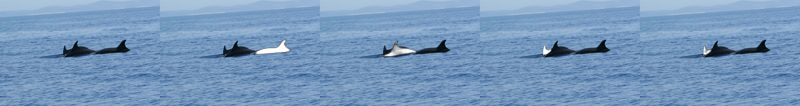

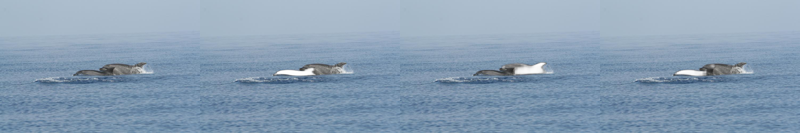

In [ ]:
show_predictions(model, data_loader=data_loader_test, n=2, score_limit=0.5)

In [ ]:
# hide_input
# def _save_model_with_timestamp(
#     model, save_path="/work/data/dupini/processed/body_100_resized/"
# ):
#     save_date_path = (
#         save_path + "model" + datetime.now().strftime("-%Y-%m-%d-%H-%M-%S") + ".pt"
#     )
#     print(save_date_path)
#     torch.save(model.state_dict(), save_date_path)

In [ ]:
# hide_input
# _save_model_with_timestamp(model)

## Metrics

In [ ]:
#exporti

def get_true_and_predicted_masks(
    model: torchvision.models.detection.mask_rcnn.MaskRCNN,
    example: Tuple[torch.Tensor, Dict[str, torch.Tensor]],
    score_limit: float = 0.5,
) -> Tuple[PIL.Image.Image, Dict[str, np.array]]:
    """ Returns a PIL image and dictionary containing both true and predicted masks as numpy arrays.
    """
    
    img = example[0]

    true_masks = (
        example[1]["masks"].mul(255).cpu().numpy().astype(np.int8)
    )

    model.eval()
    with torch.no_grad():
        predictions = model([img.to(device)])

    pred_scores = predictions[0]["scores"].cpu().numpy()

    pred_masks = predictions[0]["masks"].squeeze(1).mul(255).cpu().numpy().astype(np.int8)
    pred_masks = np.squeeze(pred_masks[np.argwhere(pred_scores > score_limit), :, :], 1)

    return ToPILImage()(img), {"true": true_masks, "predicted": pred_masks}

We have 3 dolphins on the photo, total of 4 are predicted with score higher than 0.5


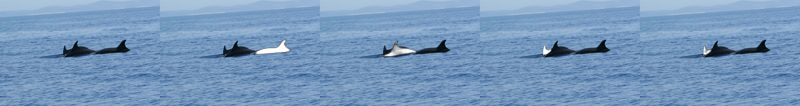

In [ ]:
#hide_input

_, masks = get_true_and_predicted_masks(model, data_loader_test.dataset[0], 0.5)
img, _ = data_loader_test.dataset[0]

print(f'We have {masks["true"].shape[0]} dolphins on the photo, total of {masks["predicted"].shape[0]} are predicted with score higher than 0.5')

assert len(masks["true"].shape) == 3
assert len(masks["predicted"].shape) == 3

show_prediction(model, img)

In [ ]:
#export

def iou_metric_pair(
    binary_segmentation: np.array,
    binary_gt_label: np.array,
) -> float:
    """
    Compute the IOU between two binary segmentation (typically one ground truth and a predicted one).
    Input:
        binary_segmentation: binary 2D numpy array representing the region of interest as segmented by the algorithm
        binary_gt_label: binary 2D numpy array representing the region of interest as provided in the database
    Output:
        IOU: IOU between the segmentation and the ground truth
    """

    assert binary_segmentation.dtype in [np.int, np.int8, np.int16, np.int32, np.bool]
    assert binary_gt_label.dtype in [np.int, np.int8, np.int16, np.int32, np.bool]
    assert len(binary_segmentation.shape) == 2
    assert len(binary_gt_label.shape) == 2

    # turn all variables to booleans, just in case
    binary_segmentation = np.asarray(binary_segmentation, dtype=np.bool)
    binary_gt_label = np.asarray(binary_gt_label, dtype=np.bool)

    # compute the intersection
    intersection = np.logical_and(binary_segmentation, binary_gt_label)
    union = np.logical_or(binary_segmentation, binary_gt_label)

    # count the number of True pixels in the binary segmentation
    segmentation_pixels = float(np.sum(binary_segmentation.flatten()))

    # same for the ground truth
    gt_label_pixels = float(np.sum(binary_gt_label.flatten()))

    # same for the intersection and union
    intersection = float(np.sum(intersection.flatten()))
    union = float(np.sum(union.flatten()))

    # compute the Dice coefficient
    smooth = 0.001
    iou = (intersection + smooth) / (union + smooth)

    return iou

Intersection over union metrics (IOU) for a pair of true and predicted masks can be calculated as follows:

In [ ]:
img, masks = get_true_and_predicted_masks(model, data_loader_test.dataset[0], 0.5)

iou_metric_pair(
    binary_segmentation=masks["predicted"][0, :, :],
    binary_gt_label=masks["true"][0, :, :],
)

0.009865235780139762

The problem with this metrics is that ordering of true and predicted masks can and usually is different. As an example, we can calculate all combinations of true and predicted masks similarities (IOU metrics). In the example bellow, we have three true masks and two predicted masks with score larger than 0.5:

In [ ]:
#export

def iou_metric_list(masks: Dict[str, np.array]) -> List[float]:
    return np.array([
        [
            iou_metric_pair(
                binary_segmentation=masks["predicted"][j, :, :],
                binary_gt_label=masks["true"][i, :, :],
            )
            for i in range(masks["true"].shape[0])
        ]
        for j in range(masks["predicted"].shape[0])
    ])
    

In [ ]:
img, masks = get_true_and_predicted_masks(model, data_loader_test.dataset[0], 0.5)

metrics = iou_metric_list(masks)

cm = sns.light_palette("lightblue", as_cmap=True)

df = pd.DataFrame(metrics)
df.style.background_gradient(cmap=cm)

,0,1,2
0,0.009865,0.000000,0.698960
1,0.609724,0.166153,0.006137
2,0.035274,0.534413,0.000000
3,0.259497,0.286330,0.000000


In the example above, we have three dolphins with three true masks, while the model predicted only two masks. This is why the matrix above has three rows and two columns. The first mask predicted by the model is represented by the first column (column 0). As we can see, the best fitting is with the second true masks (row 1). The second predicted mask is represented with the second column (column 1) and the best fit is with the first true mask (row 0).

In [ ]:
#exporti

def _argmax2d(xs: np.array) -> Tuple[int, int]:
    assert len(xs.shape) == 2
    
    n_col = xs.shape[1]
    ij = xs.argmax()
    i = ij // n_col
    j = ij % n_col
    return i, j

def _drop_max_row_and_column(xs: np.array) -> Tuple[float, np.array]:
    i, j = _argmax2d(xs)
    
    max_value = xs[i, j]

    xs = np.delete(xs, i, 0)
    xs = np.delete(xs, j, 1)

    return max_value, xs

In [ ]:
#exporti

def _resize_to_square(xs: np.array) -> np.array:
    new_size = max(xs.shape)
    new_xs = np.zeros((new_size, new_size))
    new_xs[:xs.shape[0], :xs.shape[1]] = xs
    return new_xs

In [ ]:
#hide

a = np.arange(6).reshape((3, 2))
b = np.arange(6).reshape((2, 3))

actual = _resize_to_square(a)
expected = [[0, 1, 0], [2, 3, 0], [4, 5, 0]]
np.testing.assert_array_equal(actual, expected)

actual = _resize_to_square(b)
expected = [[0, 1, 2], [3, 4, 5], [0, 0, 0]]
np.testing.assert_array_equal(actual, expected)
np.testing.assert_array_equal(actual, expected)

In [ ]:
#export

def largest_values_in_row_colums(xs: np.array) -> List[float]:
    """ Approximates the largest value in each row/column.
    """
    assert len(xs.shape) == 2

    # resize matrix to square dimensions if needed
    if xs.shape[0] != xs.shape[1]:
        xs = _resize_to_square(xs)

    assert xs.shape[0] == xs.shape[1]
    
    
    # return the only value if a single value in the matrix
    if xs.shape[0] == 1:
        return [xs[0, 0]]

    # find the largest value in the matirx and recursively find the largest values in the remaining matrix
    max_value, remainder = _drop_max_row_and_column(xs)
    return [max_value] + largest_values_in_row_colums(remainder)

In [ ]:
largest_values_in_row_colums(metrics)

[0.6989598355907723, 0.6097239252577719, 0.5344132247465444, 0.0]

In [ ]:
#export

def iou_metric(masks: Dict[str, np.array]) -> float:
    """
    Compute the IOU between two binary segmentation lists (a possibly different number of ground truths and a predicted ones).
    Input:
        binary_segmentation: binary 2D numpy array representing the region of interest as segmented by the algorithm
        binary_gt_label: binary 2D numpy array representing the region of interest as provided in the database
    Output:
        IOU: IOU between the segmentation and the ground truth
    """
    iou_matrix = iou_metric_list(masks)
    matching_ious = largest_values_in_row_colums(iou_matrix)
    iou = np.mean(matching_ious)

    return iou


Finally, we can get IOU metrics for the whole image:

In [ ]:
img, masks = get_true_and_predicted_masks(model, data_loader_test.dataset[4], 0.5)

metric = iou_metric(masks)

print(f"Average IOU metric on given example is {metric:.3f}")

Average IOU metric on given example is 0.419
